In [89]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

In [98]:
df = ML_data[['METHOD_MIC','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth']]

# creates features numpy array
features = df[df.columns[2:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE'].to_numpy()

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

#create logistic regression pipeline with preprocessing 
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression(max_iter=10000))])
#create parameter grid with different preprocessing and classifier parameters
param_grid = {'preprocessing':[StandardScaler(), MinMaxScaler(), RobustScaler(), None],
              'classifier__C': [0.01, 0.1, 1, 10, 100]}

#split data into training and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(features, label,
                                                    random_state=0)

In [100]:
# creates features and label dfs from unique mutations in the training split

#converts long X_train and y_train to pd df to join
X_train_df = pd.DataFrame(X_train1)
X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
y_train_df = pd.DataFrame(y_train1)
y_train_df.rename(columns = {0:'MUT_RESISTANCE'}, inplace = True)

CV_train = X_train_df.join(y_train_df,  how = 'inner')

#removes duplicates and mutation column
CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

#seperates into unique features and label numpy arrays
features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
label_unique = CV_train_unique['MUT_RESISTANCE']

X_train2 = (features_unique)
y_train2 = (label_unique)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [101]:
CV_train

,MUTATION,1,2,3,4,5,6,MUT_RESISTANCE
0,S315T,4.632459,-27.1,-14.0,-0.1,0.08,0.0,1
1,S315T,4.632459,-27.1,-14.0,-0.1,0.08,0.0,1
2,S315T,4.632459,-27.1,-14.0,-0.1,0.08,0.0,1
3,S315T,4.632459,-27.1,-14.0,-0.1,0.08,0.0,1
4,S315T,4.632459,-27.1,-14.0,-0.1,0.08,0.0,1
...,...,...,...,...,...,...,...,...
10234,S315T,4.632459,-27.1,-14.0,-0.1,0.08,0.0,1
10235,S315T,4.632459,-27.1,-14.0,-0.1,0.08,0.0,1
10236,S315T,4.632459,-27.1,-14.0,-0.1,0.08,0.0,1
10237,S315T,4.632459,-27.1,-14.0,-0.1,0.08,0.0,1


In [102]:
# creates features and label dfs from unique mutations in the training split

#converts long X_test and y_test to pd df to join
X_test_df = pd.DataFrame(X_test1)
X_test_df.rename(columns = {0:'MUTATION'}, inplace = True)
y_test_df = pd.DataFrame(y_test1)
y_test_df.rename(columns = {0:'MUT_RESISTANCE'}, inplace = True)

CV_test = X_test_df.join(y_test_df,  how = 'inner')

#removes duplicates and mutation column
CV_test_unique = CV_test.drop_duplicates(subset='MUTATION', keep = 'first')
CV_test_unique.drop(['MUTATION'], axis = 1, inplace = True)

#seperates into unique features and label numpy arrays
test_features_unique = CV_test_unique[CV_test_unique.columns[:-1]].to_numpy()
test_label_unique = CV_test_unique['MUT_RESISTANCE']

X_test = (test_features_unique)
y_test = (test_label_unique)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [103]:
#split data into training and test sets
X_train3, X_test2, y_train3, y_test2 = train_test_split(X_train2, y_train2,
                                                    random_state=0)

In [104]:
#Grid search with stratified cross validation
grid_strat = GridSearchCV(pipe, param_grid, cv=5)
grid_strat.fit(X_train3, y_train3)
print ('grid_strat: best estimator: \n', grid_strat.best_estimator_)
print ('grid_strat: best cross-validation score :', grid_strat.best_score_, '\n')
print ('grid_strat: test set average accuracy :', 
       accuracy_score(y_test2, grid_strat.predict(X_test2)))

grid_strat: best estimator: 
 Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier', LogisticRegression(C=0.1, max_iter=10000))])
grid_strat: best cross-validation score : 0.6635206321334504 

grid_strat: test set average accuracy : 0.7280701754385965


In [105]:
#Grid search with kfold cross validation
Kfold = KFold(n_splits=5)
grid_kfold = GridSearchCV(pipe, param_grid, cv=Kfold)
grid_kfold.fit(X_train3, y_train3)
print ('grid_kfold: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold: best cross-validation score :', grid_kfold.best_score_, '\n')
print ('grid_kfold: test set average accuracy :', 
       accuracy_score(y_test2, grid_kfold.predict(X_test2)))

grid_kfold: best estimator: 
 Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier', LogisticRegression(C=0.1, max_iter=10000))])
grid_kfold: best cross-validation score : 0.6459174714661984 

grid_kfold: test set average accuracy : 0.7280701754385965


In [106]:
#Search with shuffled cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=Kfold_shuffle)
grid_kfold_shuffle.fit(X_train3, y_train3)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test2, grid_kfold_shuffle.predict(X_test2)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', None),
                ('classifier', LogisticRegression(C=1, max_iter=10000))])
grid_kfold_shuffle: best cross-validation score:  0.6725636523266023
grid_kfold_shuffle: test set average accuracy:  0.7105263157894737 



In [107]:
#Grid search with with stratified cross validation
#use decision function to calculate average_precision
grid_strat = GridSearchCV(pipe, param_grid, cv=5, scoring='average_precision')
grid_strat.fit(X_train3, y_train3)
print ('grid_strat: best estimator: \n', grid_strat.best_estimator_)
print ('grid_strat: best cross-validation score: ', grid_strat.best_score_)                  
print ('grid_strat: test set average precision: ', 
       average_precision_score(y_test2, grid_strat.decision_function(X_test2)), '\n')

grid_strat: best estimator: 
 Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier', LogisticRegression(C=0.01, max_iter=10000))])
grid_strat: best cross-validation score:  0.7074536570409979
grid_strat: test set average precision:  0.7550762595469437 



In [108]:
#Grid search with with kfold cross validation
#use decision function to calculate average_precision
kfold = KFold(n_splits=5)
grid_kfold = GridSearchCV(pipe, param_grid, cv=kfold, scoring='average_precision')
grid_kfold.fit(X_train3, y_train3)
print ('grid_kfold: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold: best cross-validation score: ', grid_kfold.best_score_)                  
print ('grid_kfold test set average precision: ', 
       average_precision_score(y_test2, grid_kfold.decision_function(X_test2)), '\n')

grid_kfold: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=0.1, max_iter=10000))])
grid_kfold: best cross-validation score:  0.7130821481395955
grid_kfold test set average precision:  0.7550821658208867 



In [109]:
#Grid search with with shuffled cross validation
#use decision function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train3, y_train3)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test2, grid_kfold_shuffle.decision_function(X_test2)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])
grid_kfold_shuffle: best cross-validation score:  0.6971984342828523
grid_kfold_shuffle test set average precision:  0.7523960682140539 



In [110]:
#Grid search with with stratified cross validation
#use decision function to calculate AUC

grid_strat = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
grid_strat.fit(X_train3, y_train3)
print ('grid_strat: best estimator: \n', grid_strat.best_estimator_)
print ('grid_strat: best cross-validation score: ', grid_strat.best_score_)                  
print ('grid_strat: test set AUC: ', 
       roc_auc_score(y_test2, grid_strat.decision_function(X_test2)), '\n')

grid_strat: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=0.1, max_iter=10000))])
grid_strat: best cross-validation score:  0.7138884644766997
grid_strat: test set AUC:  0.7423029556650247 



In [111]:
#Grid search with with kfold cross validation
#use decision function to calculate AUC
kfold = KFold(n_splits=5)
grid_kfold = GridSearchCV(pipe, param_grid, cv=kfold, scoring='roc_auc')
grid_kfold.fit(X_train3, y_train3)
print ('grid_kfold: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold: best cross-validation score: ', grid_kfold.best_score_)                  
print ('grid_kfold test set AUC: ', 
       roc_auc_score(y_test2, grid_kfold.decision_function(X_test2)), '\n')

grid_kfold: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=0.1, max_iter=10000))])
grid_kfold: best cross-validation score:  0.724735985171891
grid_kfold test set AUC:  0.7423029556650247 



In [112]:
#Grid search with with shuffled kfold cross validation
#use decision function to calculate AUC
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train3, y_train3)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test2, grid_kfold_shuffle.decision_function(X_test2)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', None),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])
grid_kfold_shuffle: best cross-validation score:  0.7115030745260162
grid_kfold_shuffle test set AUC:  0.7524630541871922 



[0.56650246 0.56435644 0.56716418 0.57       0.57286432 0.57575758
 0.5786802  0.58163265 0.58461538 0.58247423 0.58549223 0.58333333
 0.58638743 0.58947368 0.58730159 0.59042553 0.59358289 0.59677419
 0.6        0.60326087 0.60655738 0.6043956  0.60773481 0.60555556
 0.60893855 0.60674157 0.61016949 0.61363636 0.61714286 0.62068966
 0.62427746 0.62209302 0.62573099 0.62352941 0.62130178 0.61904762
 0.62275449 0.62650602 0.63030303 0.63414634 0.63803681 0.63580247
 0.63354037 0.6375     0.64150943 0.64556962 0.64968153 0.65384615
 0.65806452 0.66233766 0.66013072 0.66447368 0.66887417 0.66666667
 0.66442953 0.66891892 0.67346939 0.67808219 0.68275862 0.6875
 0.68531469 0.69014085 0.68794326 0.69285714 0.69064748 0.69565217
 0.70072993 0.70588235 0.71111111 0.70895522 0.71428571 0.71212121
 0.70992366 0.70769231 0.70542636 0.7109375  0.70866142 0.70634921
 0.712      0.71774194 0.71544715 0.72131148 0.71900826 0.725
 0.73109244 0.72881356 0.72649573 0.72413793 0.73043478 0.72807018
 0.7

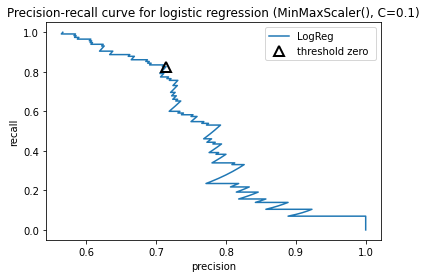

In [117]:
#use best preprocessing (standard scaler) and parameters (c=100) for av. precision
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np

pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                ('classifier', LogisticRegression(C=0.10, max_iter=10000))])
    
pipe.fit(X_train3, y_train3)
predict = (pipe.decision_function(X_test))

precision, recall, thresholds = precision_recall_curve(y_test, predict)

plt.plot(precision, recall, label='LogReg')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], '^', c='k', 
              markersize=10, label='threshold zero ', fillstyle='none', mew=2)
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')
plt.title('Precision-recall curve for logistic regression (MinMaxScaler(), C=0.1)')
    
print(precision)

Text(0.5, 1.0, 'ROC curve for logistic regression (MinMaxScaler(), C=0.1)')

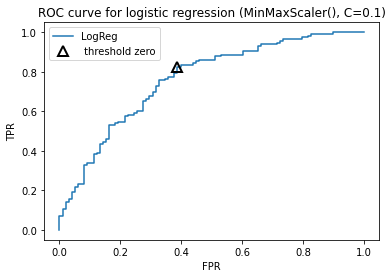

In [118]:
#use best preprocessing (standard scaler) and parameters (c=100) for av. precision
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pipe.decision_function(X_test))

plt.plot(fpr, tpr, label='LogReg')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], '^', c='k',
         markersize=10, label=' threshold zero', fillstyle='none', mew=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.title('ROC curve for logistic regression (MinMaxScaler(), C=0.1)')

In [119]:
#confusion matrix (StandardScaler, C=100)

from sklearn.metrics import confusion_matrix

#build and fit pipieline
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('classifier', LogisticRegression(C=0.1, max_iter=10000))])

pipe.fit(X_train3, y_train3)
predict = pipe.predict(X_test).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test, predict)

#calculate precision, sensitivity, specifcity, FPR, erros
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
#very_major_error = (confusion[0][1]/y_test[y_test==0].count())*100
#major_error = (confusion[1][0]/y_test[y_test==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
#print ('very major error :', very_major_error)
#print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.7142857142857143
Sensitivity:  0.8260869565217391
Specificity:  0.6122448979591837
FPR : 0.3877551020408163

 confusion matrix: 
 [[60 38]
 [20 95]]


{0: 80, 1: 133}


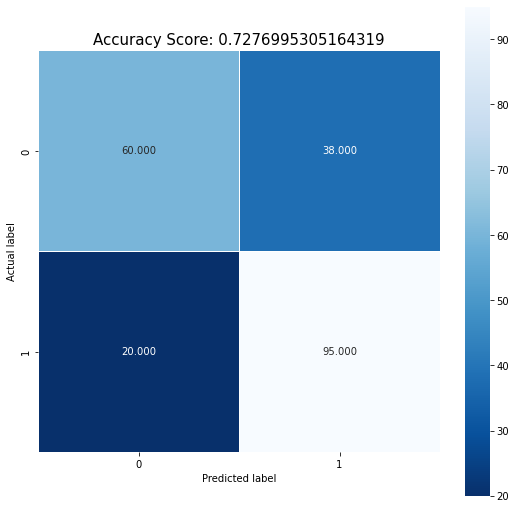

In [120]:
unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

score = pipe.score(X_test, y_test)

cm = metrics.confusion_matrix(y_test, predict)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [20]:
MIC_ML_data = ML_data.dropna(subset = ['METHOD_MIC'])

In [21]:
MIC_ML_data

,Unnamed: 0,MUTATION,UNIQUEID,DRUG,SOURCE,METHOD_1,METHOD_2,METHOD_3,METHOD_CC,METHOD_MIC,PHENOTYPE,DST_SUBJID,Number of same UNIQUEID,SITEID,SUBJID,LABID,ISOLATENO,SEQREPS,BELONGS_GPI,PER_SAMPLE_VCF_PRESENT,REGENOTYPED_VCF_PRESENT,CLOCKWORK_VERSION,TBI_INDEX,KMER_COUNTS,SNP_DISTANCE_TO_H37rV,SPECIES,LINEAGE_NAME,SUBLINEAGE_NAME,LINEAGE_PERCENTAGE,N_NULL,N_SNP,N_INDEL,N_FILTER_FAIL,N_REF,N_HET,CATALOGUE_NAME,CATALOGUE_VERSION,TB_TYPE_1,WGS_PREDICTION_STRING,IMAGE_MD5SUM,FTP_PATH,FTP_FILENAME_VCF,TREE_PATH,TREE_FILENAME_VCF,FASTQ_MD5SUMS,SEQTREAT_SAMPLE,MYKROBE_LINEAGE_NAME_1,MYKROBE_LINEAGE_NAME_2,ENA,GENE,POSITION,AMINO_ACID_NUMBER,GENOME_INDEX,NUCLEOTIDE_NUMBER,REF,ALT,IS_SNP,IS_INDEL,IN_CDS,IN_PROMOTER,IS_SYNONYMOUS,IS_NONSYNONYMOUS,IS_HET,IS_NULL,IS_FILTER_PASS,ELEMENT_TYPE,MUTATION_TYPE,INDEL_LENGTH,INDEL_1,INDEL_2,SITEID_MUT,NUMBER_NUCLEOTIDE_CHANGES,SUBJID_MUT,NUM_MUTATIONS,RESISTANCE,MEAN_RESISTANCE,N_SAME_MUTATION,MUT_RESISTANCE,Unnamed: 0.1,Residue Unique ID,Mutation,Chain,Mutation Unique ID,Site1_Distance,d_volume,d_MW,d_hydropathy,d_Pi,Start residue,End residue,"('Number of substitutions', 'min')","('Number of substitutions', 'max')","('Number of substitutions', 'count')",Depth
0,0,A106V,site.06.subj.JHL_0037-14.lab.06MIL0140.iso.1,INH,CRyPTIC,liquid media,microdilution plate,UKMYC5,0.1,0.8,R,JHL_0037-14,NaN,06,JHL_0037-14,06MIL0140,1,1,True,True,True,0.8.3,True,False,1842.0,M. tuberculosis,Lineage 1,NaN,96.650718,12081,0,1842,163,0,20028,CRyPTIC,v1.31,UNK,URURSSUURSSSSSS,{'06-JHL_0037-14-06MIL0140-1-14': '5e9b3ab0c96...,/well/bag/jeffk/release_staging/,00/00/33/76/3376/site.06.iso.1.subject.JHL_003...,dat/CRyPTIC2/V2/06/JHL_0037-14/06MIL0140/1/reg...,site.06.subj.JHL_0037-14.lab.06MIL0140.iso.1.v...,NaN,False,Mixed,lineage1.1.2/lineage4,ERS2394682,katG,106.0,106.0,NaN,NaN,gcg,gtg,True,False,True,False,False,True,False,False,True,GENE,AAM,NaN,NaN,NaN,6,1,JHL_0037-14,1,1,0.800000,5,1,16,A106_A,AV,A,A106V A,14.629585,-51.4,-28.0,-2.4,0.04,A,V,1,2,16,13.382314
3,3,A106V,site.10.subj.TRL0019243.lab.TRL0019243.iso.1,INH,CRyPTIC,liquid media,microdilution plate,UKMYC5,0.1,0.4,I,TRL0019243,NaN,10,TRL0019243,TRL0019243,1,1,True,True,True,0.8.3,True,False,684.0,M. tuberculosis,Lineage 4,S-type,100.000000,6634,0,684,63,0,11683,CRyPTIC,v1.31,UNK,UUSSSSUUSSSSSSS,{'10-TRL0019243-TRL0019243-1-7': 'eb5bd6405f0a...,/well/bag/jeffk/release_staging/,00/00/30/50/3050/site.10.iso.1.subject.TRL0019...,dat/CRyPTIC2/V2/10/TRL0019243/TRL0019243/1/reg...,site.10.subj.TRL0019243.lab.TRL0019243.iso.1.v...,NaN,False,Lineage 4,lineage4.4.1.1,ERS5298142,katG,106.0,106.0,NaN,NaN,gcg,gtg,True,False,True,False,False,True,False,False,True,GENE,AAM,NaN,NaN,NaN,10,1,TRL0019243,1,0,0.800000,5,1,16,A106_A,AV,A,A106V A,14.629585,-51.4,-28.0,-2.4,0.04,A,V,1,2,16,13.382314
9,9,A109T,site.03.subj.GB-92250159.lab.IML-01172.iso.1,INH,CRyPTIC,liquid media,microdilution plate,UKMYC6,0.1,1.6,R,GB-92250159,NaN,03,GB-92250159,IML-01172,1,1,True,True,True,0.8.3,True,False,1221.0,M. tuberculosis,Lineage 2,NaN,96.283784,4641,0,1221,111,0,15149,CRyPTIC,v1.31,MDR,RRRRSSSSRSSSSSS,{'03-GB-92250159-IML-01172-1-14': 'ef1d3e3e4c8...,/well/bag/jeffk/release_staging/,00/03/02/01/30201/site.03.iso.1.subject.GB-922...,dat/CRyPTIC2/V2/03/GB-92250159/IML-01172/1/reg...,site.03.subj.GB-92250159.lab.IML-01172.iso.1.v...,NaN,False,Lineage 2,lineage2.2.10,ERS5320073,katG,109.0,109.0,NaN,NaN,gct,act,True,False,True,False,False,True,False,False,True,GENE,AAM,NaN,NaN,NaN,3,1,GB-92250159,1,1,0.769231,13,1,53,A109_A,AT,A,A109T A,14.124010,-27.5,-30.0,2.5,0.40,A,T,1,2,16,13.902881
20,20,A109V,site.05.subj.PLE-0891.lab.LE-371.iso.1,INH,CRyPTIC,liquid media,microdilution plate,UKMYC5,0.1,0.2,I,PLE-0891,NaN,05,PLE-0891,LE-371,1,1,True,True,True,0.8.3,True,False,668.0,M. tuberculosis,Lineage 4,LAM,100.000000,14607,0,668,59,0,57447,CRyPTIC,v1.31,MDR,RRSUSSSSSSSSSSS,{'05-PLE-0891-LE-371-1-14': '95fa2a19cbb1aaef5...,/well/bag/jeffk/release_staging/,00/01/15/80/11580/site.05.iso.1.subject.PLE-08.

In [22]:
MIC_ML_data['MUTATION'].value_counts()

S315T    4275
S315N      45
W191R       8
D656A       8
Q127P       6
         ... 
L132P       1
A109T       1
D259G       1
L147R       1
L141F       1
Name: MUTATION, Length: 242, dtype: int64

In [23]:
MIC_strings = []
MIC_values = []

for i in MIC_ML_data['METHOD_MIC']:
    if i == '3.2':
        MIC_strings.append('>1.6')
    elif i == '6.4':
        MIC_strings.append('>1.6')
    elif i == '12.8':
        MIC_strings.append('>1.6')
    elif i == '>12.8':
        MIC_strings.append('>1.6')
    else:
        MIC_strings.append(i)
        
# INH had 8 wells, all start at 0.125, 8 takes you to 1.6 - then one plate had awful results (one drug) 
# gave 7 free wells - some wells given to INH (so more wells to INH new plate design)
# column called plate design - 5 has less wells, 6 is the big one (MIC lowest conc with no growth)
# if all growth, then has to be more than 1.6 
# called sensored data

# can re label all 3.2 and greater as >1.6

# look at ordinal regression

#MIC_map_values = map(float, MIC_strings)
#for i in MIC_map_values:
#    MIC_values.append(i)
    
MIC_ML_data['MIC_values'] = MIC_strings #(MIC_values for continuous data)

C:\Users\user\AppData\Local\Temp/ipykernel_41316/2547984656.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MIC_ML_data['MIC_values'] = MIC_strings #(MIC_values for continuous data)


In [24]:
MIC_ML_data

,Unnamed: 0,MUTATION,UNIQUEID,DRUG,SOURCE,METHOD_1,METHOD_2,METHOD_3,METHOD_CC,METHOD_MIC,PHENOTYPE,DST_SUBJID,Number of same UNIQUEID,SITEID,SUBJID,LABID,ISOLATENO,SEQREPS,BELONGS_GPI,PER_SAMPLE_VCF_PRESENT,REGENOTYPED_VCF_PRESENT,CLOCKWORK_VERSION,TBI_INDEX,KMER_COUNTS,SNP_DISTANCE_TO_H37rV,SPECIES,LINEAGE_NAME,SUBLINEAGE_NAME,LINEAGE_PERCENTAGE,N_NULL,N_SNP,N_INDEL,N_FILTER_FAIL,N_REF,N_HET,CATALOGUE_NAME,CATALOGUE_VERSION,TB_TYPE_1,WGS_PREDICTION_STRING,IMAGE_MD5SUM,FTP_PATH,FTP_FILENAME_VCF,TREE_PATH,TREE_FILENAME_VCF,FASTQ_MD5SUMS,SEQTREAT_SAMPLE,MYKROBE_LINEAGE_NAME_1,MYKROBE_LINEAGE_NAME_2,ENA,GENE,POSITION,AMINO_ACID_NUMBER,GENOME_INDEX,NUCLEOTIDE_NUMBER,REF,ALT,IS_SNP,IS_INDEL,IN_CDS,IN_PROMOTER,IS_SYNONYMOUS,IS_NONSYNONYMOUS,IS_HET,IS_NULL,IS_FILTER_PASS,ELEMENT_TYPE,MUTATION_TYPE,INDEL_LENGTH,INDEL_1,INDEL_2,SITEID_MUT,NUMBER_NUCLEOTIDE_CHANGES,SUBJID_MUT,NUM_MUTATIONS,RESISTANCE,MEAN_RESISTANCE,N_SAME_MUTATION,MUT_RESISTANCE,Unnamed: 0.1,Residue Unique ID,Mutation,Chain,Mutation Unique ID,Site1_Distance,d_volume,d_MW,d_hydropathy,d_Pi,Start residue,End residue,"('Number of substitutions', 'min')","('Number of substitutions', 'max')","('Number of substitutions', 'count')",Depth,MIC_values
0,0,A106V,site.06.subj.JHL_0037-14.lab.06MIL0140.iso.1,INH,CRyPTIC,liquid media,microdilution plate,UKMYC5,0.1,0.8,R,JHL_0037-14,NaN,06,JHL_0037-14,06MIL0140,1,1,True,True,True,0.8.3,True,False,1842.0,M. tuberculosis,Lineage 1,NaN,96.650718,12081,0,1842,163,0,20028,CRyPTIC,v1.31,UNK,URURSSUURSSSSSS,{'06-JHL_0037-14-06MIL0140-1-14': '5e9b3ab0c96...,/well/bag/jeffk/release_staging/,00/00/33/76/3376/site.06.iso.1.subject.JHL_003...,dat/CRyPTIC2/V2/06/JHL_0037-14/06MIL0140/1/reg...,site.06.subj.JHL_0037-14.lab.06MIL0140.iso.1.v...,NaN,False,Mixed,lineage1.1.2/lineage4,ERS2394682,katG,106.0,106.0,NaN,NaN,gcg,gtg,True,False,True,False,False,True,False,False,True,GENE,AAM,NaN,NaN,NaN,6,1,JHL_0037-14,1,1,0.800000,5,1,16,A106_A,AV,A,A106V A,14.629585,-51.4,-28.0,-2.4,0.04,A,V,1,2,16,13.382314,0.8
3,3,A106V,site.10.subj.TRL0019243.lab.TRL0019243.iso.1,INH,CRyPTIC,liquid media,microdilution plate,UKMYC5,0.1,0.4,I,TRL0019243,NaN,10,TRL0019243,TRL0019243,1,1,True,True,True,0.8.3,True,False,684.0,M. tuberculosis,Lineage 4,S-type,100.000000,6634,0,684,63,0,11683,CRyPTIC,v1.31,UNK,UUSSSSUUSSSSSSS,{'10-TRL0019243-TRL0019243-1-7': 'eb5bd6405f0a...,/well/bag/jeffk/release_staging/,00/00/30/50/3050/site.10.iso.1.subject.TRL0019...,dat/CRyPTIC2/V2/10/TRL0019243/TRL0019243/1/reg...,site.10.subj.TRL0019243.lab.TRL0019243.iso.1.v...,NaN,False,Lineage 4,lineage4.4.1.1,ERS5298142,katG,106.0,106.0,NaN,NaN,gcg,gtg,True,False,True,False,False,True,False,False,True,GENE,AAM,NaN,NaN,NaN,10,1,TRL0019243,1,0,0.800000,5,1,16,A106_A,AV,A,A106V A,14.629585,-51.4,-28.0,-2.4,0.04,A,V,1,2,16,13.382314,0.4
9,9,A109T,site.03.subj.GB-92250159.lab.IML-01172.iso.1,INH,CRyPTIC,liquid media,microdilution plate,UKMYC6,0.1,1.6,R,GB-92250159,NaN,03,GB-92250159,IML-01172,1,1,True,True,True,0.8.3,True,False,1221.0,M. tuberculosis,Lineage 2,NaN,96.283784,4641,0,1221,111,0,15149,CRyPTIC,v1.31,MDR,RRRRSSSSRSSSSSS,{'03-GB-92250159-IML-01172-1-14': 'ef1d3e3e4c8...,/well/bag/jeffk/release_staging/,00/03/02/01/30201/site.03.iso.1.subject.GB-922...,dat/CRyPTIC2/V2/03/GB-92250159/IML-01172/1/reg...,site.03.subj.GB-92250159.lab.IML-01172.iso.1.v...,NaN,False,Lineage 2,lineage2.2.10,ERS5320073,katG,109.0,109.0,NaN,NaN,gct,act,True,False,True,False,False,True,False,False,True,GENE,AAM,NaN,NaN,NaN,3,1,GB-92250159,1,1,0.769231,13,1,53,A109_A,AT,A,A109T A,14.124010,-27.5,-30.0,2.5,0.40,A,T,1,2,16,13.902881,1.6
20,20,A109V,site.05.subj.PLE-0891.lab.LE-371.iso.1,INH,CRyPTIC,liquid media,microdilution plate,UKMYC5,0.1,0.2,I,PLE-0891,NaN,05,PLE-0891,LE-371,1,1,True,True,True,0.8.3,True,False,668.0,M. tuberculosis,Lineage 4,LAM,100.000000,14607,0,668,59,0,57447,CRyPTIC,v1.31,MDR,RRSUSSSSSSSSSSS,{'05-PLE-0891-LE-371-1-14': '95fa2a19cbb1aaef5...,/well/bag/jeffk/release_staging/,00/01/15/80/11580/site.0

In [25]:
MIC_df = MIC_ML_data[['MIC_values','MUT_RESISTANCE','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth']]

# creates features numpy array
MIC_features = MIC_df[MIC_df.columns[2:]].to_numpy()

#creates resistance label column
MIC_label = MIC_df['MIC_values'].to_numpy()

In [26]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(MIC_features, MIC_label,
                                                    random_state=0)

In [27]:
#build and fit pipieline
pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', LogisticRegression(C=100, max_iter=10000))])

pipe.fit(X_train, y_train)
predict = pipe.predict(X_test)#.astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test, predict)

#calculate precision, sensitivity, specifcity, FPR, erros
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
#very_major_error = (confusion[0][1]/y_test[y_test==0].count())*100
#major_error = (confusion[1][0]/y_test[y_test==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
#print ('very major error :', very_major_error)
#print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  nan
Sensitivity:  0.0
Specificity:  1.0
FPR : 0.0

 confusion matrix: 
 [[  2   0   0   1   0   0   6   6]
 [  1   0   0   1   1   2   3   7]
 [  1   0   0   2   1   0   3   6]
 [  0   0   1   1   1   0   2  11]
 [  0   0   1   2   0   0   2  50]
 [  0   0   1   0   0   1   0 288]
 [  2   0   0   0   0   0   4   8]
 [  1   0   1   1   1   1   1 744]]


C:\Users\user\AppData\Local\Temp/ipykernel_41316/2134648971.py:12: RuntimeWarning: invalid value encountered in longlong_scalars
  Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])


{'0.05': 7, '0.2': 4, '0.4': 8, '0.8': 4, '1.6': 4, '<=0.025': 21, '>1.6': 1120}


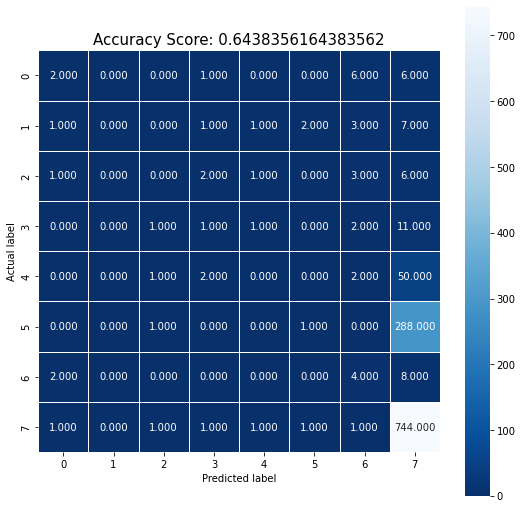

In [28]:
unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

score = pipe.score(X_test, y_test)

cm = metrics.confusion_matrix(y_test, predict)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);